In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Load Data

In [3]:
# Download Data from https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data

train_audio_path = './tensorflow-speech-recognition-challenge/train/audio/'
labels=os.listdir(train_audio_path)

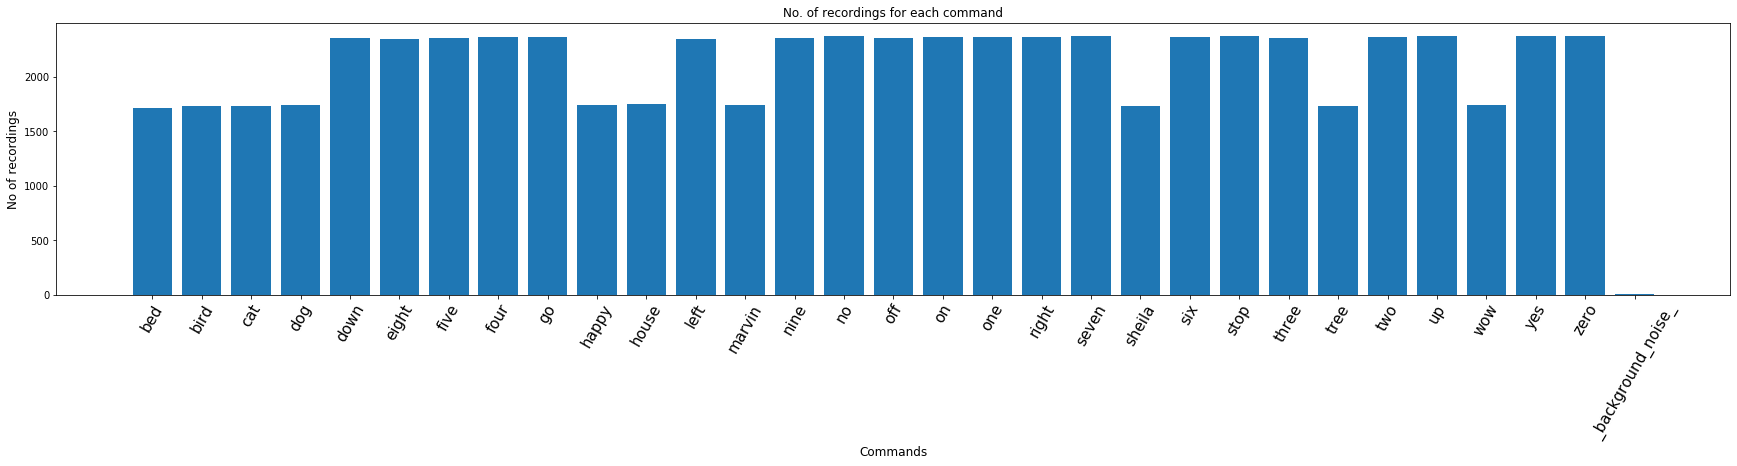

In [4]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [5]:
# Keywords Considered

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

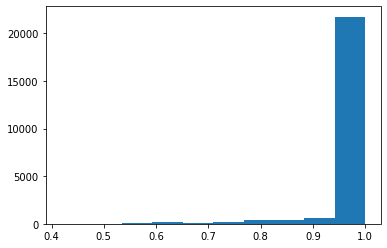

In [6]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
        
plt.figure()    
plt.hist(np.array(duration_of_recordings))
plt.show()

In [7]:
## Filtering out samples less than one second

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [15]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(classes)

all_wave = np.array(all_wave).reshape(-1,8000,1)
y = utils.to_categorical(y, num_classes=len(labels))

x_tr, x_val, y_tr, y_val = train_test_split(all_wave, y, stratify=y, test_size = 0.2, random_state=777, shuffle=True)

### Model Architecture

In [24]:
inputs = Input(shape=(8000,1), name='Input_1')

#First Conv1D layer
conv = Conv1D(8,13, padding='same', activation='relu', strides=1, name='Conv_1')(inputs)
conv = MaxPooling1D(3, name='Max_1')(conv)
conv = Dropout(0.3, name='Drop_1')(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='same', activation='relu', strides=1, name='Conv_2')(conv)
conv = MaxPooling1D(3, name='Max_2')(conv)
conv = Dropout(0.3, name='Drop_2')(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='same', activation='relu', strides=1, name='Conv_3')(conv)
conv = MaxPooling1D(3, name='Max_3')(conv)
conv = Dropout(0.3, name='Drop_3')(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='same', activation='relu', strides=1, name='Conv_4')(conv)
conv = MaxPooling1D(3, name='Max_4')(conv)
conv = Dropout(0.3, name='Drop_4')(conv)

#Fifth Conv1D layer
conv = Conv1D(64, 7, padding='same', activation='relu', strides=1, name='Conv_5')(conv)
conv = MaxPooling1D(3, name='Max_5')(conv)
conv = Dropout(0.3, name='Drop_5')(conv)

#Flatten layer
conv = Flatten(name='Flatten_1')(conv)

#Dense Layer 1
conv = Dense(256, activation='relu', name='Dense_1')(conv)
conv = Dropout(0.3, name='Drop_6')(conv)

# #Dense Layer 2
# conv = Dense(128, activation='relu')(conv)
# conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), name='logits')(conv)
outputs = Activation('softmax', name = 'probs')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 8000, 8)           112       
_________________________________________________________________
Max_1 (MaxPooling1D)         (None, 2666, 8)           0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 2666, 8)           0         
_________________________________________________________________
Conv_2 (Conv1D)              (None, 2666, 16)          1424      
_________________________________________________________________
Max_2 (MaxPooling1D)         (None, 888, 16)           0         
_________________________________________________________________
Drop_2 (Dropout)             (None, 888, 16)           0   

### Training

In [29]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('Models/best_audio.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[mc], batch_size=64, validation_data=(x_val,y_val))

Train on 17049 samples, validate on 4263 samples
Epoch 1/100
16960/17049 [============================>.] - ETA: 0s - loss: 2.0829 - acc: 0.2133
Epoch 00001: val_acc improved from -inf to 0.38517, saving model to Models/best_model.hdf5
17049/17049 [==============================] - 7s 428us/sample - loss: 2.0820 - acc: 0.2137 - val_loss: 1.7122 - val_acc: 0.3852
Epoch 2/100
17024/17049 [============================>.] - ETA: 0s - loss: 1.4012 - acc: 0.5004
Epoch 00002: val_acc improved from 0.38517 to 0.62655, saving model to Models/best_model.hdf5
17049/17049 [==============================] - 3s 204us/sample - loss: 1.4013 - acc: 0.5003 - val_loss: 1.1361 - val_acc: 0.6266
Epoch 3/100
17024/17049 [============================>.] - ETA: 0s - loss: 1.0251 - acc: 0.6500
Epoch 00003: val_acc improved from 0.62655 to 0.66057, saving model to Models/best_model.hdf5
17049/17049 [==============================] - 3s 202us/sample - loss: 1.0252 - acc: 0.6500 - val_loss: 1.0194 - val_acc: 0.66

Epoch 28/100
16896/17049 [============================>.] - ETA: 0s - loss: 0.2703 - acc: 0.9069
Epoch 00028: val_acc did not improve from 0.88435
17049/17049 [==============================] - 4s 211us/sample - loss: 0.2706 - acc: 0.9071 - val_loss: 0.3944 - val_acc: 0.8757
Epoch 29/100
16960/17049 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.9096
Epoch 00029: val_acc improved from 0.88435 to 0.88811, saving model to Models/best_model.hdf5
17049/17049 [==============================] - 4s 209us/sample - loss: 0.2602 - acc: 0.9096 - val_loss: 0.3650 - val_acc: 0.8881
Epoch 30/100
16768/17049 [============================>.] - ETA: 0s - loss: 0.2665 - acc: 0.9065
Epoch 00030: val_acc improved from 0.88811 to 0.88881, saving model to Models/best_model.hdf5
17049/17049 [==============================] - 4s 217us/sample - loss: 0.2660 - acc: 0.9065 - val_loss: 0.3696 - val_acc: 0.8888
Epoch 31/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.2729 -

Epoch 57/100
16832/17049 [============================>.] - ETA: 0s - loss: 0.1977 - acc: 0.9337
Epoch 00057: val_acc did not improve from 0.89796
17049/17049 [==============================] - 4s 212us/sample - loss: 0.1980 - acc: 0.9337 - val_loss: 0.3499 - val_acc: 0.8900
Epoch 58/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.1897 - acc: 0.9359- ETA: 1s - loss: 0
Epoch 00058: val_acc did not improve from 0.89796
17049/17049 [==============================] - 4s 210us/sample - loss: 0.1895 - acc: 0.9359 - val_loss: 0.3521 - val_acc: 0.8942
Epoch 59/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9371
Epoch 00059: val_acc did not improve from 0.89796
17049/17049 [==============================] - 4s 210us/sample - loss: 0.1871 - acc: 0.9372 - val_loss: 0.3545 - val_acc: 0.8890
Epoch 60/100
16896/17049 [============================>.] - ETA: 0s - loss: 0.1869 - acc: 0.9361
Epoch 00060: val_acc did not improve from 0.89796
17049/

Epoch 86/100
17024/17049 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9471
Epoch 00086: val_acc did not improve from 0.90124
17049/17049 [==============================] - 4s 212us/sample - loss: 0.1568 - acc: 0.9472 - val_loss: 0.3825 - val_acc: 0.8940
Epoch 87/100
16960/17049 [============================>.] - ETA: 0s - loss: 0.1617 - acc: 0.9456- E
Epoch 00087: val_acc did not improve from 0.90124
17049/17049 [==============================] - 4s 218us/sample - loss: 0.1611 - acc: 0.9459 - val_loss: 0.3786 - val_acc: 0.9003
Epoch 88/100
16832/17049 [============================>.] - ETA: 0s - loss: 0.1502 - acc: 0.9469
Epoch 00088: val_acc did not improve from 0.90124
17049/17049 [==============================] - 4s 215us/sample - loss: 0.1495 - acc: 0.9470 - val_loss: 0.3848 - val_acc: 0.8996
Epoch 89/100
16832/17049 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9481
Epoch 00089: val_acc did not improve from 0.90124
17049/17049 [=========

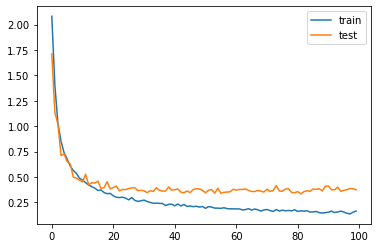

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluation

In [32]:
model=load_model('Models/best_model.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Define the function that predicts text for the given audio:

In [33]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data:

In [40]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = f1_score(y_true, y_pred, average=None)
print('the mean-f1 score: {:.4f}'.format(np.mean(class_wise_f1)))
accuracy = accuracy_score(y_true, y_pred)
print('accuracy is: {:.4f}'.format(accuracy))

[[385  17   1  13   5   1   1   4   1   2]
 [ 17 365   3  18   7   2   0   2   1   5]
 [  2   3 387   1   6   0   4   3   5  22]
 [  7   9   2 389   2   2   1   0   4   4]
 [  0   2   1   2 376  12   1   4  29   2]
 [  6   0   0   3  22 375   0   3  11   1]
 [  0   3   9   0   5   1 404   2   2   5]
 [ 10   6   3   2  15   0   1 389   9   0]
 [  2   5   5   1  19   2   1   5 371   1]
 [  2   3  11   4   6   0   1   2   0 403]]
the mean-f1 score: 0.9020
accuracy is: 0.9017


In [37]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: yes


In [38]:
print("Text:",predict(samples))

Text: yes
